# 전력수요예측 모델링

## 목차



### 1. 데이터 load

In [1]:
## module import
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import DataFrame #데이터 전처리 

from statsmodels.tsa.seasonal import seasonal_decompose # decompose
from statsmodels.tsa.stattools import adfuller # stationary test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #AutoCorrelation , Partial AutoCorrelation
import itertools # 보간
from statsmodels.tsa.arima_model import ARIMA # SARIMA랑 다른 패키지
import statsmodels.api as sm # statsmodels


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [14]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')
submission = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/submission.csv')

In [15]:
print(train.shape)
print(test.shape)

(16909, 1301)
(8760, 201)


### 2. 결측치 파악

* train 데이터셋의 경우 2016년 7월 26일 11시 ~ 2018년 6월 30일 24시까지 시간 당 전력사용량을 나타내나 80%이상의 결측치를 갖는 값이 대부분임. test셋과 train셋의 세대가 다르기 때문에 우선 test셋의 데이터로 모델링을 진행해봄

In [16]:
# to_datetime

test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

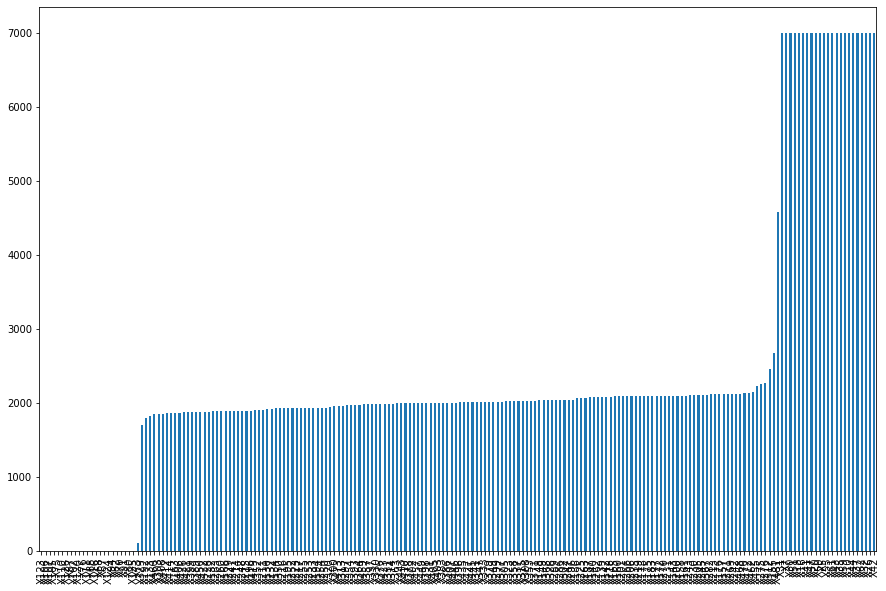

In [17]:
# 결측치 갯수 시각화
test.isnull().sum().sort_values(ascending=True).plot(kind='bar',figsize=(15,10))

* 결측치가 없는 세대를 sample로 정하여 데이터 탐색 진행

In [18]:
## 결측치가 없는 세대
test.loc[:,test.isnull().sum()==0].columns

Index(['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107'],
      dtype='object')

In [19]:
# sample 데이터
test_sample = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

* test_sample 데이터를 시간,일,월별로 resampleling

In [20]:
# 일
test_sample_day = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='D').sum()

# 월
test_sample_month = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='M').sum()

# 시간별
test_sample_hours = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

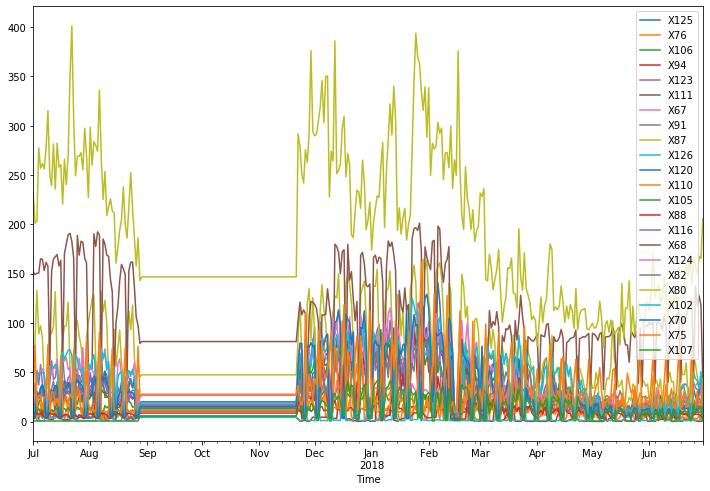

In [9]:
# 일별 전력수요량 합계

test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='D').sum().plot(figsize=(12,8))

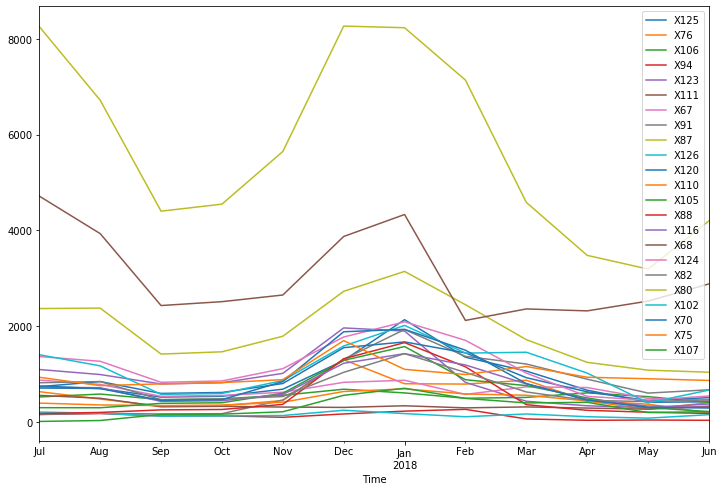

In [21]:
# 월별 전력수요량 합계

test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='M').sum().plot(figsize=(12,8))

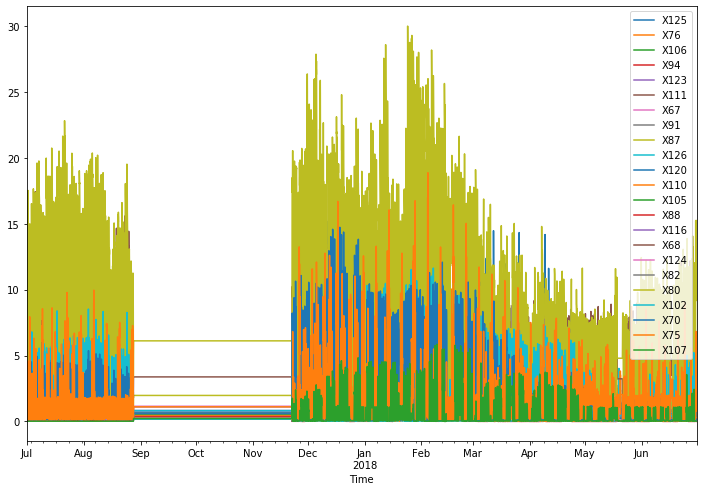

In [23]:
# 시간별 전력수요량 합계

test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].plot(figsize=(12,8))

> 결측치가 없는 test_sample에서 2017년9월~11월까지의 데이터가 같은값을 갖는 특징 확인.
    * 해당 특징이 오류인지, 특정 이유가 있는것인지 파악할 필요

> 시계열 예측을 위한 모델로 HOLT'S-WINTER, ARIMA모델을 적용해 볼것임.

> 모델 적용 전, 데이터 특성 파악 필요
    * 2017년9월~11월까지의 데이터 특징 파악
    * 주택데이터와 상가데이터의 구분
    * 계절,주말에 따른 트렌드 및 계절성 파악
    * 기온,날씨,공휴일 등 예측변수 탐색

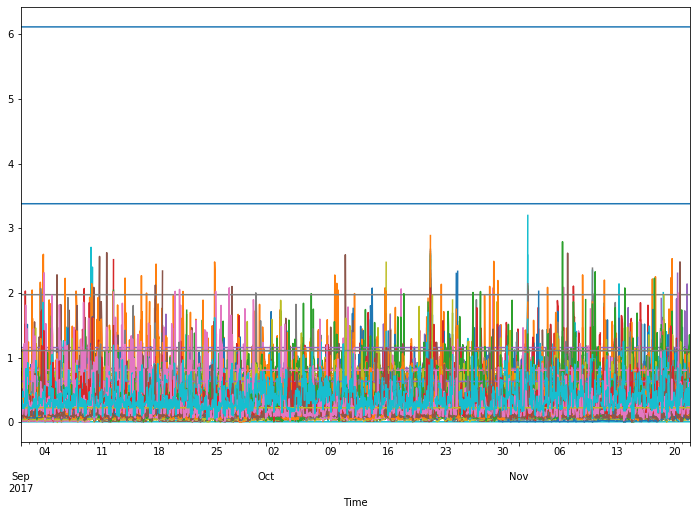

In [29]:
# test데이터 모든 데이터가 9월~11월말까지 같은 값을 갖는지 확인

test['2017-09':'2017-11-21'].plot(figsize=(12,8),legend=False)

> test셋의 모든 데이터가 17년 9월~11월말까지 같은 값을 가지는 것은 아니다.
    * 일부 데이터의 특징? vs 측정오류
    * 모델 적용시 설명력을 감소시킬 가능성 고려

* 전력수요량의 평균적인 크기로 상가와 주택을 구분해 보기

In [98]:
len(test_sample.columns)

23

In [115]:
sum_list = []

for i in range(23):
    sum_list.append(test_sample['2018-01':].resample(rule='M').mean().iloc[:,i].sum())
    
sum_series = pd.Series(sum_list)

for j,i in enumsum_series:
    

count    23.000000
mean      8.533950
std       8.767548
min       0.966934
25%       4.686495
50%       6.169866
75%       8.623566
max      42.796090
dtype: float64

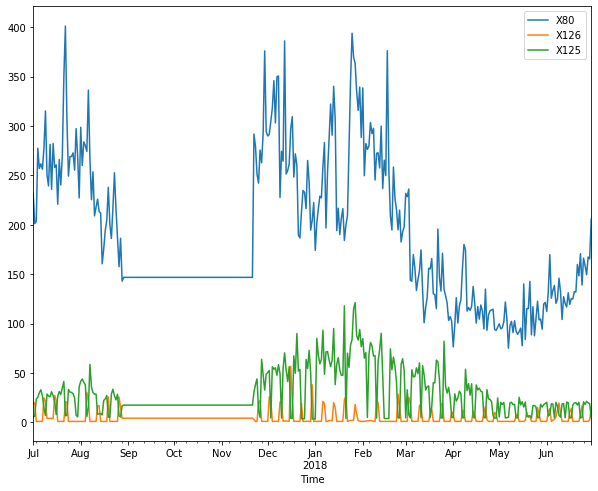

In [62]:
test_sample[['X80','X126','X125']].resample(rule='D').sum().plot(figsize=(10,8))